## Preamble

This notebook is my summary of [Aileen Nielsen's tutorial at PyCon 2017](https://youtu.be/zmfe2RaX-14), using [her ScipyTimeSeries zipped notes](https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython/blob/master/SciPyTimeSeries.zip).

In [1]:
import numpy as np
np.random.seed(47)

import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

import pandas_datareader.data as web

## Timestamps, TimeDeltas and Periods

Pandas features the usual [timestamp](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timestamp.html) and [timedelta](https://pandas.pydata.org/pandas-docs/stable/timedeltas.html) classes (equivalent to the built-in Python defaults).

#### Timestamps

In [2]:
pd.Timestamp('2016-07-10')

Timestamp('2016-07-10 00:00:00')

In [3]:
pd.Timestamp('2016-07-10 10:30:15')

Timestamp('2016-07-10 10:30:15')

In [4]:
pd.Timestamp('2016-07-10 8:15pm')

Timestamp('2016-07-10 20:15:00')

In [5]:
# Timestamps are good to 9 decimal places
ts = pd.Timestamp('2016-07-10 10:15:15.9841691261566')
print(ts)

2016-07-10 10:15:15.984169126


In [6]:
# Timestamps have a large number of convenience properties.
print(ts.quarter, ts.dayofweek, ts.is_month_start)

3 6 False


In [7]:
# strptime and strftime are used to convert timestamps from and to strings
# Pandas docs suck for these, but they're identical to time.strptime and strftime
pd.Timestamp.strptime("30 Nov 19", "%d %b %y")

Timestamp('2019-11-30 00:00:00')

In [8]:
tssp = pd.Timestamp.strptime("30 Nov 19 11:15", "%d %b %y %H:%M")
tssp.strftime(format = '%Y/%m/%d %H:%M')

'2019/11/30 11:15'

In [9]:
# Convert European-style datetime strings to timestamps
pd.to_datetime('01/07/2016', dayfirst=True)

Timestamp('2016-07-01 00:00:00')

#### TimeDeltas

In [10]:
# Possible units: 'ns', 'us', 'ms', 's', 'm', 'h', 'D'.  Can create compounds.
pd.Timedelta('1D1us') 

Timedelta('1 days 00:00:00.000001')

In [11]:
# This produces a timestamp.
pd.Timestamp('2016-07-01 8:00') + pd.Timedelta('1.5hours')

Timestamp('2016-07-01 09:30:00')

In [12]:
# Timedeltas are also good to 1 ns, but their repr only prints 6.
mytd = pd.Timedelta('500ns')

In [13]:
mytd

Timedelta('0 days 00:00:00.000000')

In [14]:
mytd.nanoseconds

500

#### Periods

[Periods](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Period.html#pandas.Period) cover periods of time, rather than single points in time.

In [15]:
p = pd.Period('7/2016')
t = pd.Timestamp('7/21/2016')
p.start_time < t and p.end_time > t

True

In [16]:
# Conversion between period and timestamp requires a frequency.
t.to_period(freq='10H')

Period('2016-07-21 00:00', '10H')

In [17]:
p.to_timestamp()

Timestamp('2016-07-01 00:00:00')

## Date and Period Ranges

We may create ranges of timestamps or periods with fixed separations.

In [18]:
pd.date_range('2016-07-10 10:15:15', end='2016-07-12 11:15:15', freq='3H30min')

DatetimeIndex(['2016-07-10 10:15:15', '2016-07-10 13:45:15',
               '2016-07-10 17:15:15', '2016-07-10 20:45:15',
               '2016-07-11 00:15:15', '2016-07-11 03:45:15',
               '2016-07-11 07:15:15', '2016-07-11 10:45:15',
               '2016-07-11 14:15:15', '2016-07-11 17:45:15',
               '2016-07-11 21:15:15', '2016-07-12 00:45:15',
               '2016-07-12 04:15:15', '2016-07-12 07:45:15',
               '2016-07-12 11:15:15'],
              dtype='datetime64[ns]', freq='210T')

In [19]:
dr = pd.date_range('2016-07-10 10:15:15', periods=3, freq='3H30min')
print(dr)

DatetimeIndex(['2016-07-10 10:15:15', '2016-07-10 13:45:15',
               '2016-07-10 17:15:15'],
              dtype='datetime64[ns]', freq='210T')


In [20]:
pr = pd.period_range('2016-07-10 10:15:15', periods=3, freq='3H30min')
print(pr)

PeriodIndex(['2016-07-10 10:15', '2016-07-10 13:45', '2016-07-10 17:15'], dtype='period[210T]', freq='210T')


In [21]:
# When checking if a timestamp is in a range, pandas will round to the accuracy
# of the range before doing the comparison.
pd.Timestamp('2016-07-10 10:15:15') in pd.period_range('2016-07-10',
                                                       end='2016-07-12', freq='1d')

True

In [22]:
# This is why the above returns True, but this returns False.
pd.Timestamp('2016-07-10 10:15:15') in pd.period_range('2016-07-10 00:00:00',
                                                       end='2016-07-12 00:00:00',
                                                       freq='3H30min')

False

#### Using ranges as indices

Ranges of times can be used as indices, which allow for time slicing of a series or data frame.

In [23]:
# B is business day!
ts_pd = pd.Series(range(45), pd.period_range(
    '2016-07-01 11:15', freq='60B', periods=45))
ts_pd.head()

2016-07-01    0
2016-09-23    1
2016-12-16    2
2017-03-10    3
2017-06-02    4
Freq: 60B, dtype: int64

In [24]:
# This also works for irregular sequences.  For period indices, the times can be irregular,
# but must periods all have the same frequencies.
ts_pd = pd.Series([3, 1, 7, 4],
                  [pd.Timestamp('2016-07-01'), pd.Timestamp('2016-07-15'),
                   pd.Timestamp('2016-07-21'), pd.Timestamp('2016-07-25')])
ts_pd['2016-07-15':'2016-07-23']

2016-07-15    1
2016-07-21    7
dtype: int64

You can pass datetime strings as indexers into either date or period indices.  Passing a datetime with less accuracy than used in the index (["partial string indexing"](https://pandas-docs.github.io/pandas-docs-travis/timeseries.html#partial-string-indexing)) will lead to slicing, while passing one with the same accuracy will lead to exact matching.  Partial string indexing works slightly differently between the two (see below).

In [25]:
ts_dt = pd.Series(range(45), pd.date_range(
    '2016-07-04', freq='31D', periods=45))
ts_pd = pd.Series(range(45), pd.period_range(
    '2016-07-04', freq='31D', periods=45))

In [26]:
# Return range of indices from the earlist timestamp starting with 2016-07
# to the last starting with 2016-12, inclusive.
ts_dt['2016-07':'2016-12']

2016-07-04    0
2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
2016-12-06    5
Freq: 31D, dtype: int64

In [27]:
# Return all periods with start dates within the date range.
ts_pd['2016-08-01':'2016-12-06']

2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
2016-12-06    5
Freq: 31D, dtype: int64

In [28]:
ts_pd['2016-08':'2016-12']

2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
2016-12-06    5
Freq: 31D, dtype: int64

In [29]:
# Return all timestamps from 2016
ts_dt['2016']

2016-07-04    0
2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
2016-12-06    5
Freq: 31D, dtype: int64

In [30]:
# Not totally sure why 2017-01-06 is included here (and using '2016/11' returns both 2016-11-05 and 2016-12-06).
ts_pd['2016']

2016-07-04    0
2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
2016-12-06    5
2017-01-06    6
Freq: 31D, dtype: int64

In [31]:
# Can also convert formats for entire range of periods/timestamps.
ts_pd.index.to_timestamp(how='start')

DatetimeIndex(['2016-07-04', '2016-08-04', '2016-09-04', '2016-10-05',
               '2016-11-05', '2016-12-06', '2017-01-06', '2017-02-06',
               '2017-03-09', '2017-04-09', '2017-05-10', '2017-06-10',
               '2017-07-11', '2017-08-11', '2017-09-11', '2017-10-12',
               '2017-11-12', '2017-12-13', '2018-01-13', '2018-02-13',
               '2018-03-16', '2018-04-16', '2018-05-17', '2018-06-17',
               '2018-07-18', '2018-08-18', '2018-09-18', '2018-10-19',
               '2018-11-19', '2018-12-20', '2019-01-20', '2019-02-20',
               '2019-03-23', '2019-04-23', '2019-05-24', '2019-06-24',
               '2019-07-25', '2019-08-25', '2019-09-25', '2019-10-26',
               '2019-11-26', '2019-12-27', '2020-01-27', '2020-02-27',
               '2020-03-29'],
              dtype='datetime64[ns]', freq='31D')

In [32]:
ts_pd.index.to_timestamp(how='end')

DatetimeIndex(['2016-08-03', '2016-09-03', '2016-10-04', '2016-11-04',
               '2016-12-05', '2017-01-05', '2017-02-05', '2017-03-08',
               '2017-04-08', '2017-05-09', '2017-06-09', '2017-07-10',
               '2017-08-10', '2017-09-10', '2017-10-11', '2017-11-11',
               '2017-12-12', '2018-01-12', '2018-02-12', '2018-03-15',
               '2018-04-15', '2018-05-16', '2018-06-16', '2018-07-17',
               '2018-08-17', '2018-09-17', '2018-10-18', '2018-11-18',
               '2018-12-19', '2019-01-19', '2019-02-19', '2019-03-22',
               '2019-04-22', '2019-05-23', '2019-06-23', '2019-07-24',
               '2019-08-24', '2019-09-24', '2019-10-25', '2019-11-25',
               '2019-12-26', '2020-01-26', '2020-02-26', '2020-03-28',
               '2020-04-28'],
              dtype='datetime64[ns]', freq='31D')

In [33]:
ts_dt.to_period(freq='31D').head()

2016-07-04    0
2016-08-04    1
2016-09-04    2
2016-10-05    3
2016-11-05    4
Freq: 31D, dtype: int64

## Time Zones

Pandas naturally handles time zones, and allows the user to freely convert between zones.

In [34]:
pd.date_range('3/6/2016 14:30:00', periods=5, freq='d', tz='Canada/Eastern')

DatetimeIndex(['2016-03-06 14:30:00-05:00', '2016-03-07 14:30:00-05:00',
               '2016-03-08 14:30:00-05:00', '2016-03-09 14:30:00-05:00',
               '2016-03-10 14:30:00-05:00'],
              dtype='datetime64[ns, Canada/Eastern]', freq='D')

In [35]:
# If a TZ is not specified, is "tz-naive"; we can localize the timestamps afterward.
pd.date_range('3/6/2016 00:00', periods=5).tz_localize('Asia/Tokyo')

DatetimeIndex(['2016-03-06 00:00:00+09:00', '2016-03-07 00:00:00+09:00',
               '2016-03-08 00:00:00+09:00', '2016-03-09 00:00:00+09:00',
               '2016-03-10 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Tokyo]', freq='D')

In [36]:
# Localized timestamps can be converted...
(pd.date_range('3/6/2016 00:00', periods=5)
 .tz_localize('Asia/Tokyo').tz_convert('Canada/Eastern'))

DatetimeIndex(['2016-03-05 10:00:00-05:00', '2016-03-06 10:00:00-05:00',
               '2016-03-07 10:00:00-05:00', '2016-03-08 10:00:00-05:00',
               '2016-03-09 10:00:00-05:00'],
              dtype='datetime64[ns, Canada/Eastern]', freq='D')

In [37]:
# In the series above, it's 10:00 AM LOCAL TIME (and not 10 AM UTC - 5 hrs).
(pd.date_range('3/6/2016 00:00', periods=5)
 .tz_localize('Asia/Tokyo').tz_convert('Canada/Eastern').tz_convert('utc'))

DatetimeIndex(['2016-03-05 15:00:00+00:00', '2016-03-06 15:00:00+00:00',
               '2016-03-07 15:00:00+00:00', '2016-03-08 15:00:00+00:00',
               '2016-03-09 15:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [38]:
# Timestamps with time zones are sensitive to daylight savings, though some care
# needs to be taken when localizing.
rng_hourly = pd.DatetimeIndex(['11/06/2011 00:00', '11/06/2011 01:00',
                               '11/06/2011 01:00', '11/06/2011 02:00','11/06/2011 03:00'])
rng_hourly.tz_localize('US/Central', ambiguous = 'infer')

DatetimeIndex(['2011-11-06 00:00:00-05:00', '2011-11-06 01:00:00-05:00',
               '2011-11-06 01:00:00-06:00', '2011-11-06 02:00:00-06:00',
               '2011-11-06 03:00:00-06:00'],
              dtype='datetime64[ns, US/Central]', freq=None)

## File I/O

Pandas's read methods have flags to auto-parse timestamps (eg. [for `read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

In [39]:
# [[0, 1]] means combine columns 0 and 1 to generate timestamp.  See documentation.
data = pd.read_fwf('data/ao_monthly.txt', header=None,
                   index_col=0, parse_dates=[[0, 1]], infer_datetime_format=True)
data.head()

,2
0_1,
1950-01-01,-0.060310
1950-02-01,0.626810
1950-03-01,-0.008128
1950-04-01,0.555100
1950-05-01,0.071577


In [40]:
# Alternatively, you could convert existing columns to datetime.
data = pd.read_fwf('data/ao_monthly.txt', header=None, names=['year', 'month', 'values'])
# Here, "assign" adds a day column, as y/m/d at minimum is necessary to pass df to pd.to_datetime.
data.index = pd.to_datetime(data[['year', 'month']].assign(day=1), errors='ignore')
data.drop(labels=['year', 'month'], axis=1, inplace=True)

## Resampling

Pandas series of timestamps and periods have [asfreq](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.asfreq.html) and [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) methods

In [41]:
t_ind = pd.date_range('2019-1-1', periods=108, freq='1H')
ts = pd.Series(np.arange(t_ind.shape[0]), index=t_ind)

`ts.asfreq` performs a simple resampling, only allowing forward or backward fill to take care of intervening data points.

In [42]:
# foward fill - imputes intervening data points with most recent data point
# (eg. 12:45 has 12:00's value)
converted = ts.asfreq('45Min', method='ffill')
converted.head()

2019-01-01 00:00:00    0
2019-01-01 00:45:00    0
2019-01-01 01:30:00    1
2019-01-01 02:15:00    2
2019-01-01 03:00:00    3
Freq: 45T, dtype: int64

In [43]:
# backward fill - imputes intervening data points with first subsequent data point
# (eg. 12:45 has 1:00's value)
converted = ts.asfreq('45Min', method='bfill')
converted.head()

2019-01-01 00:00:00    0
2019-01-01 00:45:00    1
2019-01-01 01:30:00    2
2019-01-01 02:15:00    3
2019-01-01 03:00:00    3
Freq: 45T, dtype: int64

In [44]:
# None leads to NaNs (which can be filled using fillna)
converted = ts.asfreq('45Min', method=None)
converted.head()

2019-01-01 00:00:00    0.0
2019-01-01 00:45:00    NaN
2019-01-01 01:30:00    NaN
2019-01-01 02:15:00    NaN
2019-01-01 03:00:00    3.0
Freq: 45T, dtype: float64

In [45]:
converted = ts.asfreq('45Min', method=None).fillna(method='ffill', limit=2)
converted[:10]

2019-01-01 00:00:00    0.0
2019-01-01 00:45:00    0.0
2019-01-01 01:30:00    0.0
2019-01-01 02:15:00    NaN
2019-01-01 03:00:00    3.0
2019-01-01 03:45:00    3.0
2019-01-01 04:30:00    3.0
2019-01-01 05:15:00    NaN
2019-01-01 06:00:00    6.0
2019-01-01 06:45:00    6.0
Freq: 45T, dtype: float64

`ts.resample` is much more flexible, and can replicate the behaviour of `asfreq`, or provide true resampling by using summary statistics (`mean`, `median`) or interpolation.  Syntatically, it works similar to `groupby`.

In [46]:
ts.resample('10Min').ffill().head()

2019-01-01 00:00:00    0
2019-01-01 00:10:00    0
2019-01-01 00:20:00    0
2019-01-01 00:30:00    0
2019-01-01 00:40:00    0
Freq: 10T, dtype: int64

In [47]:
ts.resample('1D').median().head()

2019-01-01     11.5
2019-01-02     35.5
2019-01-03     59.5
2019-01-04     83.5
2019-01-05    101.5
Freq: D, dtype: float64

In [48]:
ts.resample('5Min').interpolate(kind='quadratic').head()

2019-01-01 00:00:00    0.000000
2019-01-01 00:05:00    0.083333
2019-01-01 00:10:00    0.166667
2019-01-01 00:15:00    0.250000
2019-01-01 00:20:00    0.333333
Freq: 5T, dtype: float64

In [49]:
# Resample can also handle irregular (but ordered) sequences.
irreg_ts = ts.loc[np.random.choice(a=ts.index, size=10, replace=False)].sort_index()
irreg_ts.resample('2h').interpolate(kind='quadratic').head()

2019-01-01 00:00:00    0.0
2019-01-01 02:00:00    2.0
2019-01-01 04:00:00    4.0
2019-01-01 06:00:00    6.0
2019-01-01 08:00:00    8.0
Freq: 2H, dtype: float64

In [50]:
irreg_ts.resample('D').count()

2019-01-01    5
2019-01-02    2
2019-01-03    1
2019-01-04    2
Freq: D, dtype: int64

## Moving Window Functions

We typically want to smooth out high frequency variations to better understand an overall trend.  Pandas as the built-in [rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html) method which returns a `Rolling` class instance.  As with `groupby` or `resample`, we may use summary statistics on `Rolling`.

In [51]:
sineblock = np.concatenate([
    np.sin(np.arange(600) / 10.)[:, None],
    np.sin(np.arange(600) / 7.)[:, None],
    np.cos(np.arange(600) / 7.)[:, None],], axis=1)
df = pd.DataFrame(sineblock,
                  index=pd.date_range('5/1/2016', freq ='D', periods = 600),
                  columns = ['A', 'B', 'C'])

In [52]:
df.rolling(window=20).mean().iloc[10:25]

,A,B,C
2016-05-11,NaN,NaN,NaN
2016-05-12,NaN,NaN,NaN
2016-05-13,NaN,NaN,NaN
2016-05-14,NaN,NaN,NaN
2016-05-15,NaN,NaN,NaN
2016-05-16,NaN,NaN,NaN
2016-05-17,NaN,NaN,NaN
2016-05-18,NaN,NaN,NaN
2016-05-19,NaN,NaN,NaN
2016-05-20,0.684751,0.677753,0.147049


By default, `Rolling` associates each aggregate value with the last label in the window.  Here `'2016-05-20'` is assigned the mean of the first 20 timestamps (everything before that gets a `NaN` because there aren't enough values for the window).  This corresponds to a lag equal to that of the window.  We can get rid of this by using `center=True`.

<IPython.core.display.Javascript object>


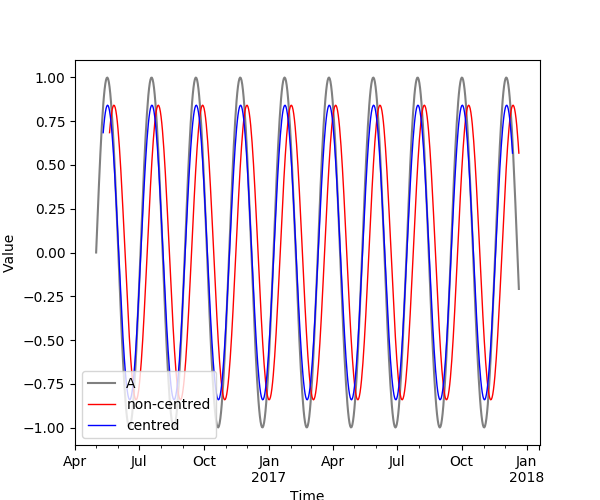

In [53]:
fig, ax = plt.subplots(1, figsize=[6, 5])
df['A'].plot(ax=ax, color='gray')
df.rolling(window=20).mean()['A'].plot(color='r', label='non-centred', lw=1)
df.rolling(window=20, center=True).mean()['A'].plot(color='b', label='centred', lw=1)
ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Value');

You can artifically shift your time using the `shift` method:

In [54]:
df.shift(-10).head()

,A,B,C
2016-05-01,0.841471,0.989903,0.141746
2016-05-02,0.891207,1.000000,-0.000632
2016-05-03,0.932039,0.989723,-0.142998
2016-05-04,0.963558,0.959282,-0.282449
2016-05-05,0.985450,0.909297,-0.416147


In [55]:
df.shift(-10).tail()

,A,B,C
2017-12-17,NaN,NaN,NaN
2017-12-18,NaN,NaN,NaN
2017-12-19,NaN,NaN,NaN
2017-12-20,NaN,NaN,NaN
2017-12-21,NaN,NaN,NaN


Likewise, there are expanding and exponentially moving windows.  Using the former with `mean` just leads to a regression to the mean, since more and more of the total data is included in the mean.  The latter weights historical values with a damping factor, and can be calculated recursively using the formula ([Wikipedia](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average)):

$$
S_t = \alpha Y_t + (1 - \alpha) Y_{t-1}
$$

where $S_1 = Y_1$.  For example, setting $\alpha = 0.5$ downweights historical values by $2^\mathrm{-lag}$ ($\mathrm{lag}$ being the number of steps between the historical and current value).

<IPython.core.display.Javascript object>


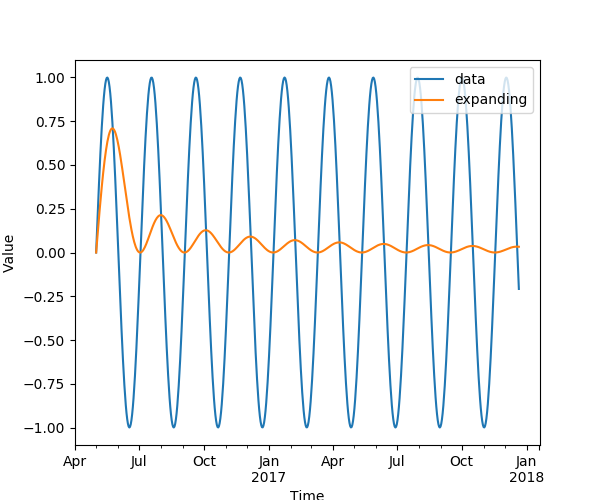

In [56]:
fig, ax = plt.subplots(1, figsize=[6, 5])
df['A'].plot(ax=ax, label='data')
df['A'].expanding(min_periods = 1).mean().plot(ax=ax, label='expanding')
ax.legend(loc=1)
ax.set_xlabel('Time')
ax.set_ylabel('Value');

<IPython.core.display.Javascript object>


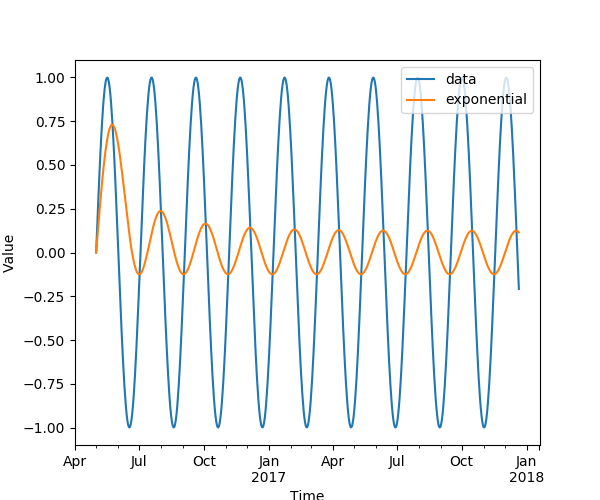

In [57]:
fig, ax = plt.subplots(1, figsize=[6, 5])
df['A'].plot(ax=ax, label='data')
df['A'].ewm(span=160, min_periods=0, adjust=True).mean().plot(ax=ax, label='exponential')
ax.legend(loc=1)
ax.set_xlabel('Time')
ax.set_ylabel('Value');